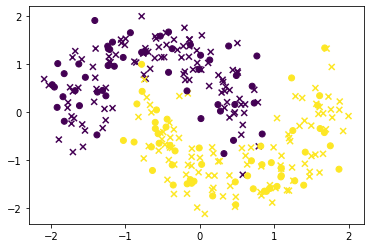

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.linear_model import Lasso

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_moons


n = 300
n_tr = 200
X, y = make_moons(n, shuffle=True, noise=0.2, random_state=112)
y[y==0] = -1

# standardise the data
trmean = np.mean(X[:n_tr, :], axis=0)
trvar = np.var(X[:n_tr, :], axis=0)
X = (X - trmean[np.newaxis, :]) / np.sqrt(trvar)[np.newaxis, :]

# take first n_tr as training, others as test.
Xtr = X[:n_tr, :]
ytr = y[:n_tr]
Xt = X[n_tr:, :]
yt = y[n_tr:]

# inspect the dataset visually
plt.figure()
plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, marker='x')
plt.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o')
plt.show()

# the parameters to consider in cross-validation
# order lasso params from largest to smallest so that if ties occur CV will select the one with more sparsity
params_lasso = [1, 1e-1, 1e-2, 1e-3, 1e-4]
params_rbf = [1e-3, 1e-2, 1e-1, 1, 10, 100]
params_svm = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]  # smaller C: more regularisation

# the noisy features to be considered; for n noisy features, add the first n columns
n_tot_noisy_feats = 50
np.random.seed(92)
X_noise = 2*np.random.randn(X.shape[0], n_tot_noisy_feats)
Xtr_noise = X_noise[:n_tr, :]
Xt_noise = X_noise[n_tr:, :]

In [ ]:
svm_accs = []
lasso_accs = []
lasso_n_feats = []

k = 5 # for k-fold validation

# do CV over the parameters

amount_of_noisy_feats = np.arange(n_tot_noisy_feats+1) # include both 0 and 50
for n_noisy_feats in amount_of_noisy_feats:
    print(n_noisy_feats)
    # print("\n\nUsing %d noisy feats \n" %n_noisy_feats)
    Xtr_noisy = np.copy(Xtr) 
    Xt_noisy = np.copy(Xt)
    if n_noisy_feats > 0:
        Xtr_noisy = np.hstack((Xtr_noisy, Xtr_noise[:, :n_noisy_feats])) 
        Xt_noisy = np.hstack ((Xt_noisy, Xt_noise[:, :n_noisy_feats]))
    lasso_validation_accs = np.zeros((k, len(params_lasso)))
    svm_validation_accs = np.zeros((k, len (params_rbf), len (params_svm)))

    # make the training-validation splits on the training data
    kf = KFold(n_splits=k)
    foldindx = 0


    # what do these splits look like?
    # cv_visualisation = []
    # for train_index, validation_index in kf.split(Xtr_noisy): 
    #     cv_vis_row = np.zeros(Xtr_noisy.shape[0])
    #     cv_vis_row[validation_index] = 1
    #     cv_visualisation.append(cv_vis_row)
    # cv_visualisation = np.array(cv_visualisation)
    # plt.matshow(cv_visualisation)
    # plt.show()
    # exit(":)")

    #perform the cross-validation
    for train_index, validation_index in kf.split(Xtr_noisy):
        # now then get the results on all the parameters considered!
        # here for SVM with the two parameters
        for gindx, gamma in enumerate (params_rbf):
            for sindx, svmparam in enumerate (params_svm):
                svm = SVC(C=svmparam, gamma=gamma)
                svm.fit(Xtr_noisy[train_index, :], ytr[train_index])
                preds = svm.predict(Xtr_noisy [validation_index])
                svm_validation_accs [foldindx, gindx, sindx] = accuracy_score (ytr[validation_index], preds)
        # here for lasso with the one parameter
        for lindx, lassoparam in enumerate (params_lasso):
            lasso = Lasso (alpha=lassoparam)
            lasso.fit(Xtr_noisy[train_index, :], ytr[train_index])
            preds = np.sign (lasso.predict(Xtr_noisy[validation_index]))
            lasso_validation_accs[foldindx, lindx] = accuracy_score (ytr[validation_index], preds)
        foldindx += 1
    # now, average results over folds
    lasso_validation_avg = np.mean (lasso_validation_accs, axis=0)
    svm_validation_avg = np.mean (svm_validation_accs, axis=0)

    # get the indexes of the best parameters and get the parameters at these indices
    best_lasso_param = params_lasso[np.argmax(lasso_validation_avg)]
    [best_svm_gamma_indx, best_svm_C_indx] = np.unravel_index(np.argmax(svm_validation_avg, axis=None), svm_validation_avg.shape) 
    best_svm_gamma = params_rbf [best_svm_gamma_indx]
    best_svm_C = params_svm [best_svm_C_indx]
    print("best lasso parameter is: ", best_lasso_param)
    print("best gamma parameter is: ", best_svm_gamma)
    print("best svm parameter is: ", best_svm_C)
    # train with the whole training data with the chosen parameters
    svm = SVC(C=best_svm_C, gamma=best_svm_gamma)
    svm.fit(Xtr_noisy, ytr)
    svm_preds = svm.predict(Xt_noisy)
    svm_accs.append(accuracy_score (yt, svm_preds))
    lasso = Lasso (alpha=best_lasso_param) 
    lasso.fit(Xtr_noisy, ytr)
    lasso_preds = np.sign(lasso.predict(Xt_noisy)) 
    lasso_accs.append(accuracy_score (yt, lasso_preds))
    # out of interest: how many features did lasso select? 
    lasso_n_feats.append(np.count_nonzero (lasso.coef_))


lasso was better than svm for the first time with 5 noisy features


Text(0.5, 1.0, '#lasso feats')

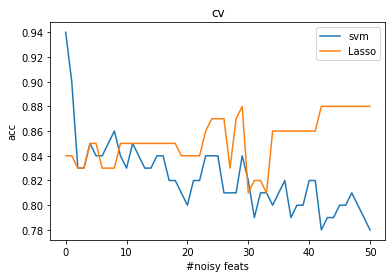

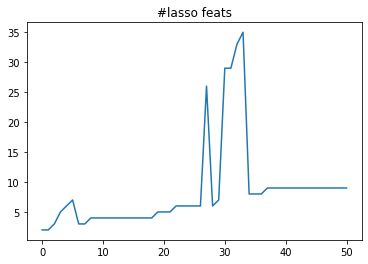

In [11]:
# finally, plot the results
plt.figure()
plt.plot(amount_of_noisy_feats, svm_accs, label="svm")
plt.plot(amount_of_noisy_feats, lasso_accs, label="Lasso")
plt.title("cv")
plt.xlabel("#noisy feats")
plt.ylabel("acc")
plt.legend()
#plt.show()

#extract the answer to the question (or look at the plot)
svm_accs = np.array (svm_accs)
lasso_accs = np.array (lasso_accs)

print("lasso was better than svm for the first time with %d noisy features" % (np.where(svm_accs-lasso_accs <0)[0][0]))

plt.figure()
plt.plot(amount_of_noisy_feats, lasso_n_feats)
plt.title("#lasso feats")

0
best lasso params:  {'alpha': 0.1}
best svm params:  {'C': 1, 'gamma': 1}
1
best lasso params:  {'alpha': 0.1}
best svm params:  {'C': 10, 'gamma': 1}
2
best lasso params:  {'alpha': 0.1}
best svm params:  {'C': 100, 'gamma': 0.001}
3
best lasso params:  {'alpha': 0.01}
best svm params:  {'C': 100, 'gamma': 0.001}
4
best lasso params:  {'alpha': 0.01}
best svm params:  {'C': 1, 'gamma': 0.01}
5
best lasso params:  {'alpha': 0.01}
best svm params:  {'C': 10, 'gamma': 0.001}
6
best lasso params:  {'alpha': 0.1}
best svm params:  {'C': 10, 'gamma': 0.001}
7
best lasso params:  {'alpha': 0.1}
best svm params:  {'C': 10, 'gamma': 0.01}
8
best lasso params:  {'alpha': 0.1}
best svm params:  {'C': 1000, 'gamma': 0.001}
9
best lasso params:  {'alpha': 0.1}
best svm params:  {'C': 100, 'gamma': 0.001}
10
best lasso params:  {'alpha': 0.1}
best svm params:  {'C': 1, 'gamma': 0.01}
11
best lasso params:  {'alpha': 0.1}
best svm params:  {'C': 100, 'gamma': 0.001}
12
best lasso params:  {'alpha'

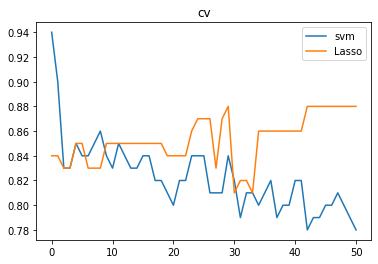

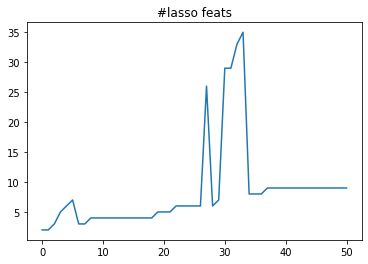

In [16]:
svm_accs = []
lasso_accs = []
lasso_n_feats = []

k = 5 # for k-fold validation

# do CV over the parameters

for n_noisy_feats in amount_of_noisy_feats:
    print(n_noisy_feats)
    # print("\n\nUsing %d noisy feats \n" %n_noisy_feats)
    Xtr_noisy = np.copy(Xtr) 
    Xt_noisy = np.copy(Xt)
    if n_noisy_feats > 0:
        Xtr_noisy = np.hstack((Xtr_noisy, Xtr_noise[:, :n_noisy_feats])) 
        Xt_noisy = np.hstack ((Xt_noisy, Xt_noise[:, :n_noisy_feats]))
    lasso_validation_accs = np.zeros((k, len(params_lasso)))
    svm_validation_accs = np.zeros((k, len (params_rbf), len (params_svm)))

    # let sklearn handle the grid search CV
    from sklearn.model_selection import GridSearchCV
    # need to define a "scorer" based on accuracy to give to it
    def my_accuracy_score (ytrue, ypred):
        return accuracy_score (np.sign (ytrue), np.sign(ypred))
    from sklearn.metrics import make_scorer
    my_acc_scorer = make_scorer (my_accuracy_score)

    # grid search cv for Lasso
    cscv_lasso = GridSearchCV(estimator=Lasso(), param_grid= {"alpha": params_lasso}, scoring= my_acc_scorer, cv=KFold(5)) 
    cscv_lasso.fit(Xtr_noisy, ytr)
    lasso_preds = np.sign(cscv_lasso.best_estimator_.predict(Xt_noisy))
    print("best lasso params: ", cscv_lasso.best_params_)
    # same for svm, now with the two parameters
    cscv_svm = GridSearchCV(SVC(), param_grid= {"C": params_svm, "gamma" :params_rbf}, scoring=my_acc_scorer, cv=KFold(5)) 
    cscv_svm.fit(Xtr_noisy, ytr)
    svm_preds = np.sign (cscv_svm.best_estimator_.predict(Xt_noisy))
    print("best svm params: ", cscv_svm.best_params_)

    # get the accuracies on test data
    svm_accs.append(accuracy_score (yt, svm_preds))
    lasso_accs.append(accuracy_score (yt, lasso_preds))
    # out of interest extract also the number of non-zero lasso coefficients 
    lasso_n_feats.append(np.count_nonzero (cscv_lasso.best_estimator_.coef_))

plt.figure()
plt.plot(amount_of_noisy_feats, svm_accs, label="svm")
plt.plot(amount_of_noisy_feats, lasso_accs, label="Lasso")
plt.title("cv")
plt.legend()
# plt.show()
svm_accs = np.array (svm_accs)
Lasso_accs = np.array(lasso_accs)

print("lasso was better than svm for the first time with %d noisy features" % (np.where(svm_accs-lasso_accs<0)[0][0]))
plt.figure()
plt.plot(amount_of_noisy_feats, lasso_n_feats)
plt.title("#lasso feats")
plt.show()